# A Bootstrap Method for One Sample Hypothesis Testing

A one sample test determines whether or not a sample statistic is statistically different from a population value. We will use now a bootstrap method with the same purpose.

A bootstrap hypothesis test starts with a test statistic - ***t(x)*** (not necessary an estimate of a parameter).

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  
from statsmodels.distributions.empirical_distribution import ECDF

## Generating data

Let's start generating ficticious data.

In [2]:
# Generating data
np.random.seed(1234)
data = np.random.randint(158, 175, 50)

In [3]:
sample_mean = np.mean(data)
print(sample_mean)

167.54


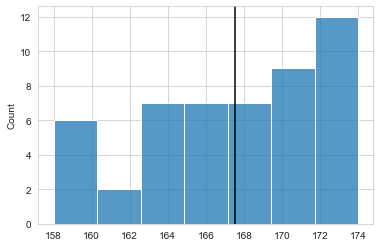

In [4]:
sns.histplot(x=data)
plt.axvline(x=np.mean(sample_mean), color='black');

As you can see, our data does not follow a normal distribution.

## Calculating the sample distribution using bootstrap

Let's define `generateSamples` function to generate samples WITH REPLACEMENT using `data`.

In [5]:
def generateSamples(sample_data, num_samples=10000, sample_size=100):
    '''
    It returns a DataFrame where each column is a sample.
    '''
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)    

Let's generate 10,000 samples, and save them into a DataFrame.

In [6]:
dfSamples = generateSamples(data, num_samples=10000, sample_size=40)
print(dfSamples.shape)
dfSamples.head()

(40, 10000)


,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S9990,S9991,S9992,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,170,164,163,174,158,173,169,170,173,173,...,170,174,167,170,170,174,169,173,160,173
1,174,163,172,169,170,164,173,170,164,169,...,158,158,168,169,164,168,160,163,160,163
2,166,173,170,170,169,160,158,170,167,165,...,169,170,168,160,169,164,160,170,164,160
3,174,161,167,163,170,174,169,173,163,169,...,170,174,163,170,164,169,169,167,174,169
4,174,164,174,165,167,169,167,174,169,170,...,169,169,165,161,173,163,160,169,160,172


We are going to use the mean as our statistic test.

`sample_distribution_mean` is a list with the mean of all samples.

In [7]:
sample_distribution_mean = dfSamples.mean() 

This is the histogram of `sample_distribution_mean`:

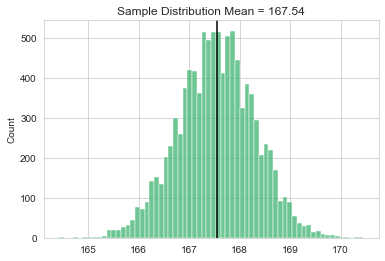

In [8]:
sns.histplot(x=sample_distribution_mean, color='mediumseagreen')
plt.axvline(x=np.mean(sample_distribution_mean), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_mean)));

This is a kde plot of `sample_distribution_mean`:

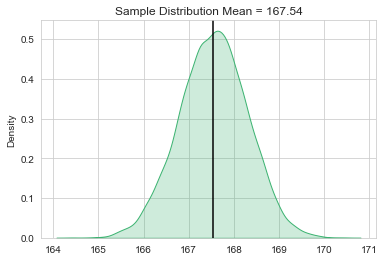

In [9]:
sns.kdeplot(x=sample_distribution_mean, color='mediumseagreen', shade=True)
plt.axvline(x=np.mean(sample_distribution_mean), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_mean)));

## The hypothesis

Suppose we want to test the hypothesis:
- `Ho: mean   = 170`
- `Ha: mean != 170`

The first step is to construct the sample distribution under Ho; we need to build a sample distribution with a mean of `170`.

In [10]:
sample_distribution_Ho = sample_distribution_mean - np.mean(sample_distribution_mean) + 170

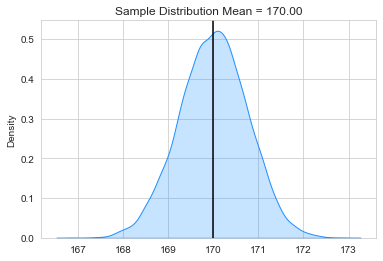

In [11]:
sns.kdeplot(x=sample_distribution_Ho, color='dodgerblue', shade=True)
plt.axvline(x=np.mean(sample_distribution_Ho), color='black')
plt.title('Sample Distribution Mean = %.2f' %(np.mean(sample_distribution_Ho)));

## Critical Regions

We have three critical regions, according to the hypothesis we want to prove:
- left
- right
- two-sided

To calculate the p-values, we will use two variables:
- `sample_distribution_Ho`: sample distribution under Ho
- `test_value`: hypothesized value

Let's define alpha = 0.05

In [12]:
alpha = 0.05

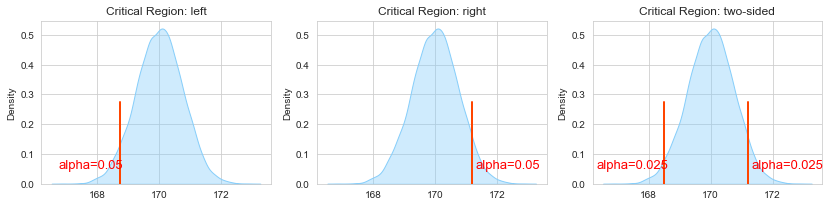

In [13]:
plt.figure(figsize=(14,3))

plt.subplot(131)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
cv1 = np.percentile(sample_distribution_Ho, alpha*100)              # left critical value   
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-2, 0.05, 'alpha=0.05', color='red', size='13')
plt.title('Critical Region: left')

plt.subplot(132)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)          # right critical value 
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv2+0.1, 0.05, 'alpha=0.05', color='red', size='13')
plt.title('Critical Region: right')

plt.subplot(133)
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
cv1 = np.percentile(sample_distribution_Ho, (alpha/2)*100)          # left critical value 
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)          # right critical value      
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-2.2, 0.05, 'alpha=0.025', color='red', size='13')
plt.text(cv2 + 0.1, 0.05, 'alpha=0.025', color='red', size='13')
plt.title('Critical Region: two-sided')

plt.show();


## Calculating the p-value

The p-value is the probability of getting a test statistic more extreme than the one we have calculated from our sample, given Ho is true.

We reject Ho if our p-value is small enough.

For calculating the p-value we will:
- Calculate the number of simulated test stats that are more extreme than our hipothesized `test_value`
- Calculate it using the empirical distribution function (ECDF)

Both options are equivalent. They get the same result.

Let's start defining the `test_value`:

In [14]:
test_value = 170

### p-value for alternative hypothesis: `smaller` (critical region: left)



- `Ho: measure = test_value`
- `Ha: measure <  test_value`

In our case, we will be testing: 

- `Ho: mean = 170`
- `Ha: mean < 170`

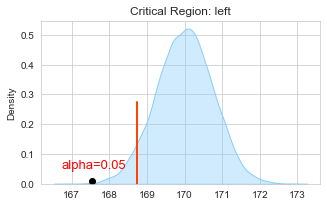

In [15]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
plt.plot(sample_mean, 0.01, 'o', color='black')
cv1 = np.percentile(sample_distribution_Ho, alpha*100)              # left critical value 
plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv1-2, 0.05, 'alpha=0.05', color='red', size='13')
plt.title('Critical Region: left');

Let's calculate the number of simulated test stats that are less than or equal to our `sample_mean`

p-value here is the area under the curve from -infinity to the `sample_mean`

In [16]:
lowtail = np.sum(np.array(sample_distribution_Ho)<=sample_mean)
pval_s = lowtail/(len(sample_distribution_Ho))
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)

Smaller alternative hypothesis: p-value = 0.0006


Let's calculate the p-value using the empirical distribution.

In [17]:
# Creating the empirical distribution
ecdf = ECDF(sample_distribution_Ho)

In [18]:
pval_s = ecdf(sample_mean)
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)

Smaller alternative hypothesis: p-value = 0.0006


As you can see, both values are the same.

### p-value for alternative hypothesis: `larger` (critical region: right)

- `Ho: measure = test_value`
- `Ha: measure > test_value`

In our case, we will be testing: 

- `Ho: mean = 170`
- `Ha: mean > 170`

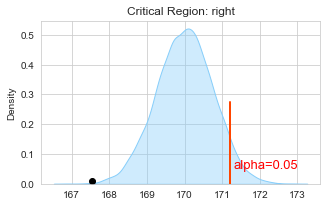

In [19]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
plt.plot(sample_mean, 0.01, 'o', color='black')
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)      # right critical value
plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.text(cv2+0.1, 0.05, 'alpha=0.05', color='red', size='13')
plt.title('Critical Region: right');

p-value here is 1 - the area under the curve (pfd) from the `sample_mean` to infinity because it is a right critical region.

Let's calculate the number of simulated test stats that are greater than to our original `sample_mean`.

In [20]:
upptail = np.sum(np.array(sample_distribution_Ho)>sample_mean)
pval_l = upptail/(len(sample_distribution_Ho))
print('Larger alternative hypothesis: p-value = %.4f' %pval_l)

Larger alternative hypothesis: p-value = 0.9994


Let's calculate the p-value using the empirical distribution.

In [21]:
pval_l = 1 - ecdf(sample_mean)
print('Larger alternative hypothesis: p-value = %.4f' %pval_l)

Larger alternative hypothesis: p-value = 0.9994


Both ways produce the same p-value.

Notice that you can add both p-values (smaller and larger) and get 1. That is because they are complementaries.

In [22]:
print('Smaller alternative hypothesis: p-value = %.4f' %pval_s)
print('Larger alternative hypothesis: p-value  = %.4f' %pval_l)
print('Adding both values: %.1f' %(pval_s + pval_l))

Smaller alternative hypothesis: p-value = 0.0006
Larger alternative hypothesis: p-value  = 0.9994
Adding both values: 1.0


### p-value for alternative hypothesis: `two-sided` (critical region: two-sided)

- `Ho: measure  = test_value`
- `Ha: measure != test_value`

In our case, we will be testing: 

- `Ho: mean  = 170`
- `Ha: mean != 170`

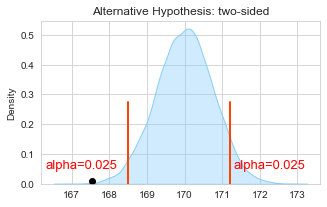

In [23]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
plt.plot(sample_mean, 0.01, 'o', color='black')
cv1 = np.percentile(sample_distribution_Ho, (alpha/2)*100)     # left critical value 
cv2 = np.percentile(sample_distribution_Ho, 100-alpha*100)     # right critical value
plt.axvline(x=cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
plt.axvline(x=cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
plt.text(cv1-2.2, 0.05, 'alpha=0.025', color='red', size='13')
plt.text(cv2+0.1, 0.05, 'alpha=0.025', color='red', size='13')
plt.title('Alternative Hypothesis: two-sided');

To calculate the p-value when the alternative hypothesis is two-sided, we need to determine whether the test_value is to the right or left in our graph, calculate the p-value in the usual way, and then duplicate it.

Let's calculate the minimum of number of simulated test stats that are:
- less than or equal to test_vales, 
- greater than test_value

In [24]:
lowtail = np.sum(np.array(sample_distribution_Ho)<=sample_mean)
upptail = np.sum(np.array(sample_distribution_Ho) >sample_mean)
pval_t = 2*np.min([lowtail, upptail])/len(sample_distribution_Ho)
print('Two-tailed test p-value = %.4f' %pval_t)

Two-tailed test p-value = 0.0012


Using ecdf:

In [25]:
if sample_mean < np.mean(sample_distribution_Ho): 
    pval_t = 2*ecdf(sample_mean)
else: pval_t = 2*(1 - ecdf(sample_mean))
print('Two-tailed test p-value = %.4f' %pval_t)

Two-tailed test p-value = 0.0012


You do not need to use both methods to get the p-value. You can use any of them.

Let's summarize the p-value calculation in one function:

In [26]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value
    sample_distribution: the sample distribution
    obs_value: observed value 
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [27]:
pval = getpValue(sample_distribution_Ho, sample_mean, alternative='smaller')
print('For alternative hypothesis smaller: p_value = %.4f' % pval)

For alternative hypothesis smaller: p_value = 0.0006


In [28]:
pval = getpValue(sample_distribution_Ho, sample_mean, alternative='larger')
print('For alternative hypothesis larger: p_value = %.4f' % pval)

For alternative hypothesis larger: p_value = 0.9994


In [29]:
pval = getpValue(sample_distribution_Ho, sample_mean)
print('For alternative hypothesis two-sided: p_value = %.4f' % pval)

For alternative hypothesis two-sided: p_value = 0.0012


## One Sample Hypothesis Test with Bootstrapping

We have:
- data: a representative sample
- The hypothesis we want to test


We want to define a function for hypothesis testing.

### Defining one_sample_HT

We will create a function for the hypothesis test. We could receive `data` as a parameter and use it to determine its mean and the sample distribution. The calculation of sample distribution is time-consuming, and we could use the same sample distribution to test several hypotheses. So, we decided to receive it as a parameter instead of calculating it in each call to the function.

In [30]:
def one_sample_HT(sampl_value, sampl_distribution, pop_value, alpha=0.05, alternative='two-sided'):
    '''
    sampl_value: observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    pop_value: population mean
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrap One-Sample Hypothesis Test ---')
    print('    Ho: measure  =', np.round(pop_value, 2))    
    print('    Ha: measure', sigHa[alternative], np.round(pop_value, 2))    
    print('    Sample Mean = %.2f' %(sampl_value))  
    sampl_distribution_Ho = sampl_distribution - np.mean(sampl_distribution) + pop_value
    sns.kdeplot(x=sampl_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)   # plotting the sample distribution
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)          # plotting the statistic 
    plt.title('Sampling Distribution')
    p_val = getpValue(sampl_distribution_Ho, sampl_value, alternative)
    if alternative=='two-sided':        # plotting the graph with two critical regions
        cv1 = np.round(np.percentile(sampl_distribution_Ho, (alpha/2)*100),2)           # left critical value     
        cv2 = np.round(np.percentile(sampl_distribution_Ho, 100-alpha*100),2)           # right critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)  
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    elif alternative=='smaller':        # plotting the graph with left critical region
        cv1 = np.round(np.percentile(sampl_distribution_Ho, alpha*100),2)               # left critical value 
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:                               # plotting the graph with right critical region
        cv2 = np.round(np.percentile(sampl_distribution_Ho, 100-alpha*100),2)           # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    p-value = '+str(np.round(p_val,4)))



Let's use the function `one_sample_HT` with `data` for the hypothesis:
- `Ho: mean = 170`
- `Ha: mean != 170`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 170
    Ha: measure != 170
    Sample Mean = 167.54
    p-value = 0.0012


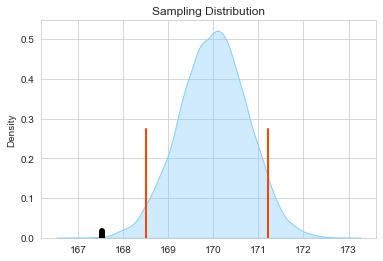

In [31]:
one_sample_HT(sample_mean, sample_distribution_mean, 170)

p-value < 0.05, we reject Ho. We conclude the mean is different from 170.

Let's analyse:
- `Ho: mean = 168`
- `Ha: mean != 168`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 168
    Ha: measure != 168
    Sample Mean = 167.54
    p-value = 0.5438


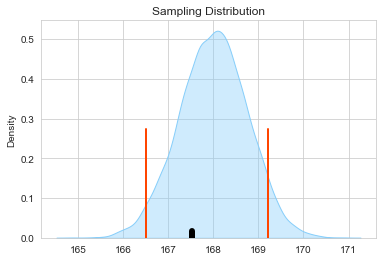

In [32]:
one_sample_HT(sample_mean, sample_distribution_mean, 168)

There are no reasons for rejecting Ho, and we cannot affirm the mean is different from 168.

Let's analyse:
- `Ho: mean = 166`
- `Ha: mean > 166`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 166
    Ha: measure >  166
    Sample Mean = 167.54
    p-value = 0.0186


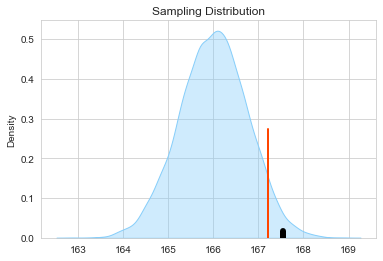

In [33]:
one_sample_HT(sample_mean, sample_distribution_mean, 166, alternative='larger')

p-value < 0.05, therefore we reject Ho and conclude the mean is greater than 166.

Let's compare this result with the traditional t-test.

### The traditional one-sample t-test

In [34]:
def graph_one_sample_ttest(sample, pop_value, alpha=0.05, alternative='two-sided'):
    '''
    sample: list of values
    pop_value: poblational mean
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- One sample t-test ---')
    print('    Ha: mean = ', np.round(pop_value,2))
    print('    Ha: mean', sigHa[alternative], np.round(pop_value,2))    
    print('Sample Mean = %.2f' %(np.mean(sample)))
    alt={'two-sided':'two-sided','smaller':'less','larger':'greater'}
    t_stat, pval = st.ttest_1samp(sample, pop_value, alternative=alt[alternative])
    print('t-value = %.3f    p-value = %.4f' %(t_stat, pval))
    if pval < alpha:    
        print("%.4f <= %.2f We are rejecting the null hypothesis" %(pval, alpha))
    else:
        print("%.4f > %.2f We have no reasons to reject the null hypothesis" %(pval, alpha))
    df = len(sample) - 1    
    if alternative=='two-sided':            # plotting the graph with two critical regions
        cv1 = st.t.ppf(alpha/2,df)          # left critical value 
        cv2 = st.t.ppf(1-alpha/2,df)        # right critical value 
        x1 = np.arange(-4, cv1, 0.01)
        plt.fill_between(x=x1, y1=st.t.pdf(x1,df), facecolor='red', alpha=0.6) 
        x2 = np.arange(cv1, cv2, 0.01)   
        plt.fill_between(x=x2, y1=st.t.pdf(x2,df), facecolor='lightskyblue', alpha=0.5) 
        x3 = np.arange(cv2, 4, 0.01)   
        plt.fill_between(x=x3, y1=st.t.pdf(x3,df), facecolor='red', alpha=0.6)  
        plt.plot(t_stat, 0.005, 'o', color='black')     # plotting the statistic t_stat
    elif alternative=='smaller':            # plotting the graph with left critical region
        cv1 = st.t.ppf(alpha,df)            # left critical value 
        x1 = np.arange(-4, cv1, 0.01)
        plt.fill_between(x=x1, y1=st.t.pdf(x1,df), facecolor='red', alpha=0.6)
        x2 = np.arange(cv1, 4, 0.01)   
        plt.fill_between(x=x2, y1=st.t.pdf(x2,df), facecolor='lightskyblue', alpha=0.5) 
        plt.plot(t_stat, 0.005, 'o', color='black')     # plotting the statistic t_stat
    else:                                   # plotting the graph with right critical region
        cv1 = st.t.ppf(1-alpha,df)          # right critical value 
        x1 = np.arange(-4, cv1, 0.01)
        plt.fill_between(x=x1, y1=st.t.pdf(x1,df), facecolor='lightskyblue', alpha=0.5)
        x2 = np.arange(cv1, 4, 0.01)   
        plt.fill_between(x=x2, y1=st.t.pdf(x2,df), facecolor='red', alpha=0.6) 
        plt.plot(t_stat, 0.005, 'o', color='black')     # plotting the statistic t_stat     

--- One sample t-test ---
    Ha: mean =  166
    Ha: mean >  166
Sample Mean = 167.54
t-value = 2.283    p-value = 0.0134
0.0134 <= 0.05 We are rejecting the null hypothesis


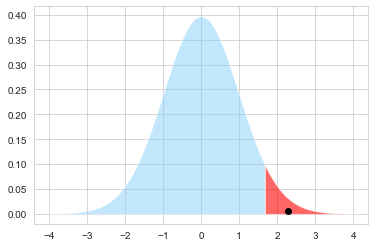

In [35]:
graph_one_sample_ttest(data, 166, alternative='larger')

### Testing the variance

Let's run the bootstrap hypothesis test for the variance.

The first step is calculate the sample distribution for the variance and the variance of our sample.

In [36]:
sample_distribution_var = dfSamples.var()

In [37]:
sample_var = np.var(data)

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 20
    Ha: measure != 20
    Sample Mean = 22.29
    p-value = 0.5404


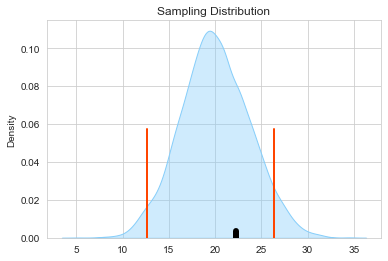

In [38]:
one_sample_HT(sample_var, sample_distribution_var, 20)

There are no reasons for rejecting Ho. The sample variance is not significantly different from 20.

What about variance = 30? Let's formulate the hypothesis:
- `Ho: var  = 30`
- `Ha: var != 30`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 30
    Ha: measure != 30
    Sample Mean = 22.29
    p-value = 0.0368


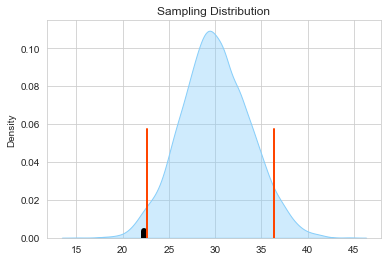

In [39]:
one_sample_HT(sample_var, sample_distribution_var, 30)

We reject Ho, the sample variance is not 30.

We can test:
- `Ho: var = 30`
- `Ha: var < 30`

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 30
    Ha: measure <  30
    Sample Mean = 22.29
    p-value = 0.0184


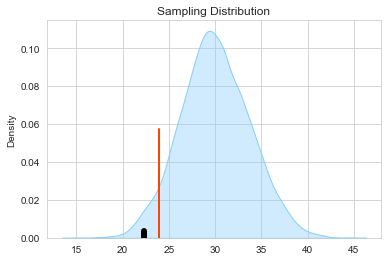

In [40]:
one_sample_HT(sample_var, sample_distribution_var, 30, alternative='smaller')

And indeed 22.29 < 30

### Testing the skew

Let's use the bootstrapping method to test the hypothesis involving the skewness of data:

- `Ho: skew = 0`
- `Ha: skew < 0`

We stat calculating the sample distribution for the skewness.

In [41]:
sample_distribution_skew = dfSamples.skew()

In [42]:
from scipy.stats import skew

In [43]:
sample_skew = skew(data)

--- Bootstrap One-Sample Hypothesis Test ---
    Ho: measure  = 0
    Ha: measure <  0
    Sample Mean = -0.43
    p-value = 0.0453


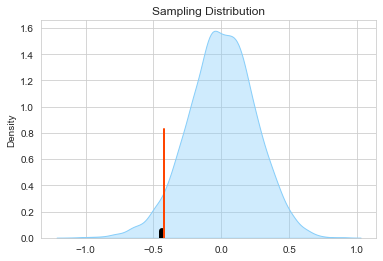

In [44]:
one_sample_HT(sample_skew, sample_distribution_skew, 0, alternative='smaller')

We conclude the skewness is significantly less than 0.